In [1]:
import pickle
from sklearn.cluster import DBSCAN
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
import mach_functions
import cv2
import os
import argparse

In [57]:
# where the binary files are:
cases = ['ram','rod','hyp','amoe','dys'] # 5 case

filedir = "/home/binsun/microglia_MACH/all_results/184" # change this to the directory where you put the binary file

In [58]:
# readin the binary image

bimage = {i:np.load(filedir+"/"+i+"binary") for i in cases}

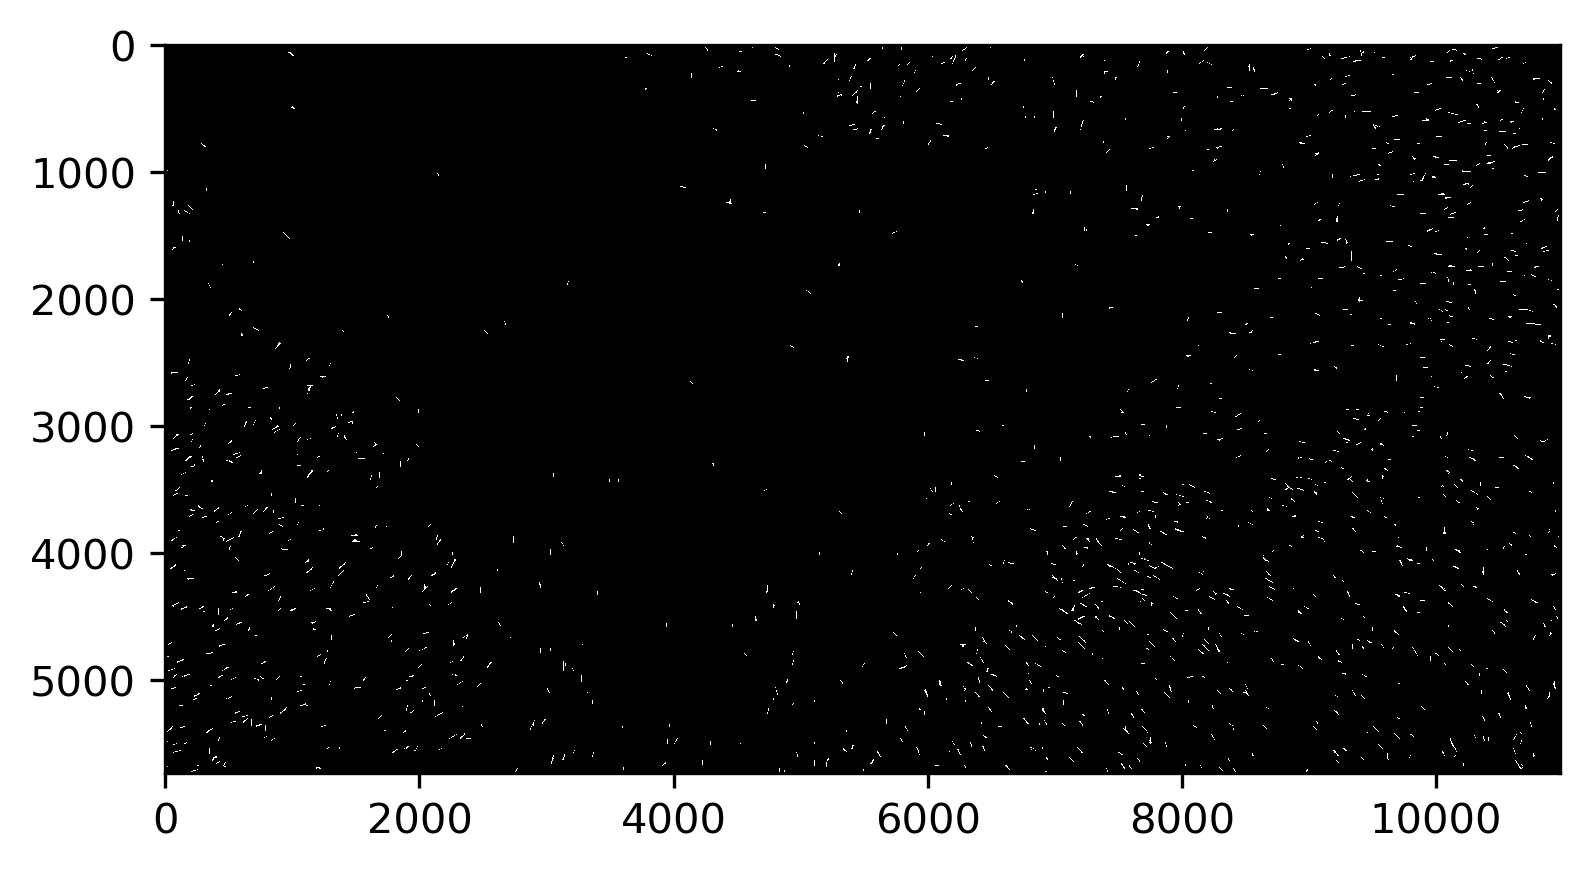

In [59]:
plt.figure(dpi=300)
plt.imshow(bimage['rod'],cmap='gray')

In [60]:
# get the centoid of each detected cells
def getCellLocations(bimage):
    """
    Get the locations of detected cells
    """
    lbl = ndimage.label(bimage)[0]
    coords = ndimage.measurements.center_of_mass(bimage, lbl,list(range(1,np.max(lbl)+1)))
    coords = np.asarray(coords)
    
    return coords
    



In [61]:
locations = {i:getCellLocations(bimage[i]) for i in cases}

In [62]:
print (locations['rod'])

[[1.30573770e+01 4.28727869e+03]
 [1.22661290e+01 4.62512903e+03]
 [9.64480874e+00 4.87057923e+03]
 ...
 [5.71710256e+03 4.87695897e+03]
 [5.71721121e+03 6.93254310e+03]
 [5.72072358e+03 1.06335854e+04]]


In [63]:
def drawLocations(location):
    """
    Draw the cells using the coords (in unit of pixels)
    """
    fig, ax = plt.subplots()
    im = ax.scatter(location[:,0], location[:,1])
    plt.gca().invert_yaxis()

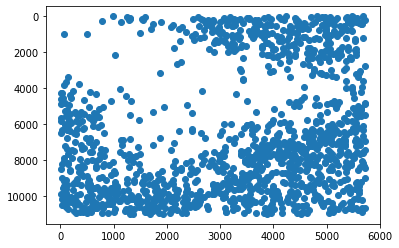

In [64]:
drawLocations(locations['rod'])

In [65]:
# DBSCAN
from sklearn.cluster import DBSCAN

In [66]:
# Parameters for DBSCAN
Minpt = 50 # min_samples, 50 cells
Eps = 1000 # circle radius, 1000 pixels 

In [67]:
db = DBSCAN(eps=Eps, min_samples=Minpt, metric = 'euclidean',algorithm ='auto')

In [68]:
db.fit(locations['rod'])



DBSCAN(algorithm='auto', eps=1000, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=50, n_jobs=None, p=None)

In [69]:
from matplotlib.colors import ListedColormap

#discrete color scheme

clusterColors  =  ['gray', 'lime', 'green','forestgreen','darkgreen'] # maximum 4 clusters


In [70]:
def dbSCAN(locs,Eps=1000,Minpt=50):
    """
    Performing DBSCAN on the binary result images
    locs -- the location of the centroid of detected cells, in the coordinate of pixels
    """
    
    # temporarily assume maxium 4 cluters are detected
    clusterColors  =  ['gray', 'lime', 'green','forestgreen','darkgreen']
    clusterLabels = ['Noise','c1','c2','c3','c4']
    db = DBSCAN(eps=Eps, min_samples=Minpt, metric = 'euclidean',algorithm ='auto')
    db.fit(locs)
    
    
    Nclusters =len(np.unique(db.labels_)) - 1
    cMap = ListedColormap(clusterColors[0:Nclusters+1])
 #("Found %d clusters with density %5.2f " % (Nclusters, Minpt/Eps))
    plt.figure(figsize=(6,4),dpi=300)
    fig, ax = plt.subplots()
    im = ax.scatter(locs[:,0], locs[:,1], c=db.labels_,cmap=cMap)
    plt.gca().invert_yaxis()
    cbar = fig.colorbar(im, ax=ax,ticks=np.unique(db.labels_))
    cbar.ax.set_yticklabels(clusterLabels[0:Nclusters+1])
    ax.text(0,-1000,"Found %d clusters with density %5.2f " % (Nclusters, Minpt/Eps),color='red',fontsize=14)
    

<Figure size 1800x1200 with 0 Axes>

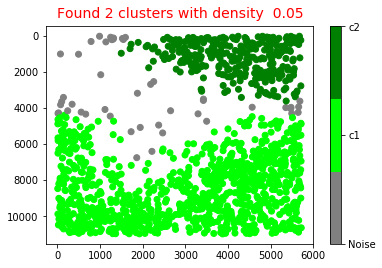

In [71]:
dbSCAN(locations['rod'])



<Figure size 1800x1200 with 0 Axes>

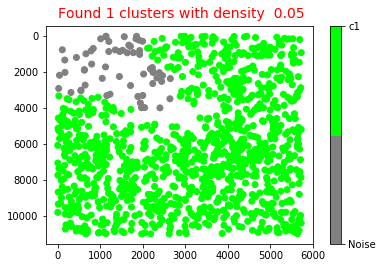

In [72]:
dbSCAN(locations['amoe'])

<Figure size 1800x1200 with 0 Axes>

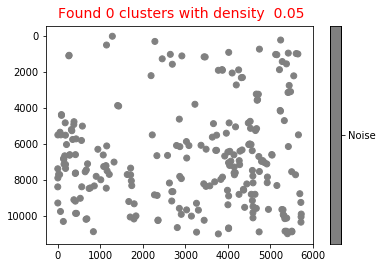

In [73]:
dbSCAN(locations['ram'])

<Figure size 1800x1200 with 0 Axes>

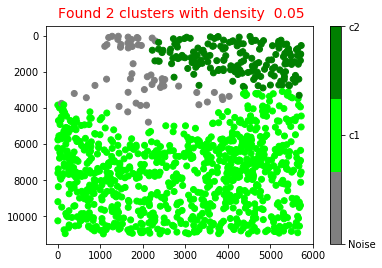

In [74]:
dbSCAN(locations['dys'])

<Figure size 1800x1200 with 0 Axes>

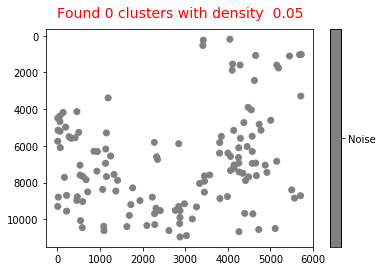

In [75]:
dbSCAN(locations['hyp'])

In [21]:
from scipy.spatial.distance import pdist

In [24]:
from scipy.spatial.distance import squareform

In [38]:
print (locations['rod'])

[[1.30573770e+01 4.28727869e+03]
 [1.22661290e+01 4.62512903e+03]
 [9.64480874e+00 4.87057923e+03]
 ...
 [5.71710256e+03 4.87695897e+03]
 [5.71721121e+03 6.93254310e+03]
 [5.72072358e+03 1.06335854e+04]]


In [45]:
def avgMinDist(locs):
    """
    Find the average minimum distance of cells
    """
    
    mindist = {}
    for i in locs.keys():
        mindist[i] = []
        dist = pdist(locs[i])
    
        sqY = np.sort(squareform(dist),axis=1)
    
        meandist = np.mean(sqY[:,1])
        std = np.std(sqY[:,1])
        mindist[i] = [meandist,std]
    return mindist

In [82]:
def plotavgDist(mindist):
    """
    plot the average minimum distance
    """
    micronsPerPixel = 0.22
    idx = 0
    plt.figure(dpi=200)
    colors = ['green','red','blue','cyan','yellow']
    cells = ['ram','rod','hyp','a']
    for i,j in dis.items():
        idx += 1
        plt.bar(idx,j[0]*micronsPerPixel,yerr=j[1]*micronsPerPixel,color=colors[idx-1],label=i)

    plt.legend()
    plt.xticks(np.arange(1,6),)
    plt.ylabel("Average Minimum Dist. ($\mu$m)")
    

In [83]:
dis = avgMinDist(locations)

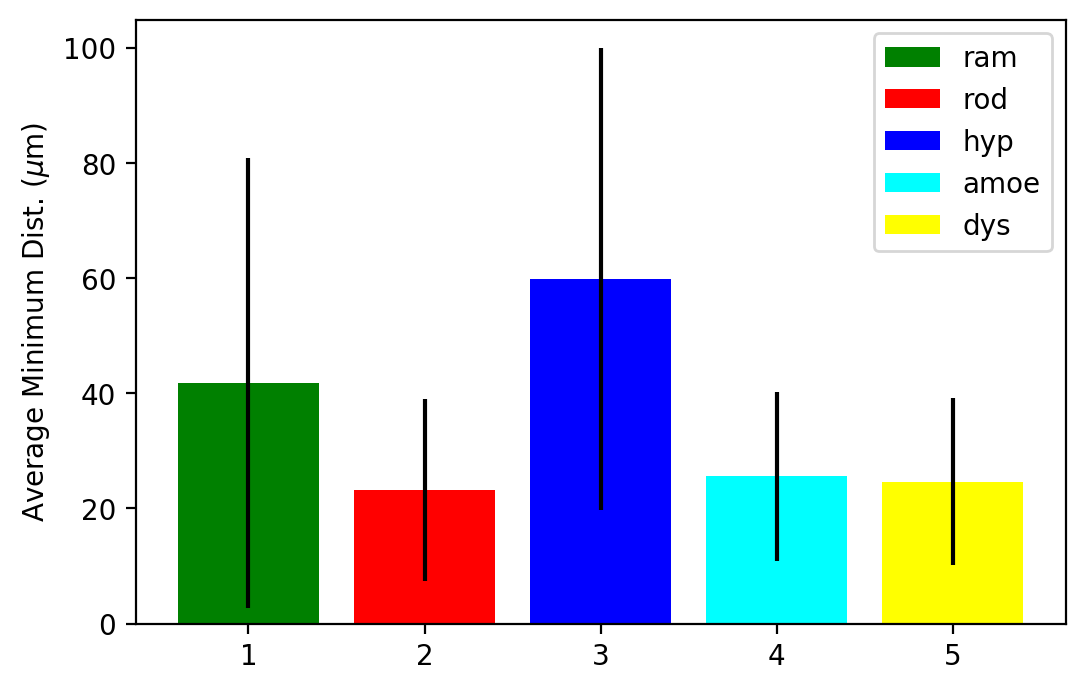

In [84]:
plotavgDist(dis)

In [97]:
def calculatePCC(image1,image2):
    """
    Calculate the Pearson's Correlation Coefficeint between two images (the same size)
    """
       
    nX,nY = image1.shape # the dimension of images
    nP = nX*nY # total number of pixels
    
    
    avgIn1 = np.sum(image1)/nP # average pixel intensity of image 1
    avgIn2 = np.sum(image2)/nP # average pixel intensity of image 2
    
    Numerator = 0.0
    Denom1 = 0.0
    Denom2 = 0.0
    
    for i in range(nX):
        for j in range(nY):
            Numerator += (image1[i,j] - avgIn1)*(image2[i,j] - avgIn2)
            Denom1 += (image1[i,j] - avgIn1)**2
            Denom2 += (image2[i,j] - avgIn2)**2
    pcc = Numerator/(np.sqrt(Denom1)*np.sqrt(Denom2))
    
    return pcc
            
    

        
    

In [116]:
def detectionPCC(bimage):
    """
    Calculate the PCC between every two cell types
    """
    #total combinations
    combo = combinations(['ram','rod','hyp','amoe','dys'],2)
    pcc = {}
    for i in combo:
        pcc[str(i[0])+"_"+str(i[1])] = calculatePCC(bimage[i[0]],bimage[i[1]])
    return pcc

In [117]:

allPCC = detectionPCC(bimage)

In [156]:
for i in allPCC.items():
      print ("PCC_%s is %f" % (i[0],i[1]))

PCC_ram_rod is -0.003268
PCC_ram_hyp is -0.002790
PCC_ram_amoe is -0.002283
PCC_ram_dys is -0.002927
PCC_rod_hyp is -0.004728
PCC_rod_amoe is -0.004051
PCC_rod_dys is -0.006002
PCC_hyp_amoe is -0.003459
PCC_hyp_dys is -0.005122
PCC_amoe_dys is -0.004192


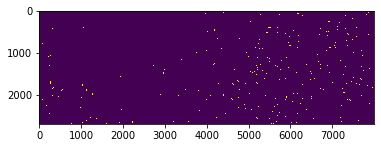

In [127]:
plt.imshow(bimage['rod'][3000:5700,2000:10000])

In [149]:
smallBiamge = {}
for i in bimage.keys():
    smallBiamge[i] = bimage[i][3000:5700,7000:10000]

In [136]:

smallPCC = detectionPCC(smallBiamge)

In [139]:
for i in smallPCC.items():
    print ("PCC_%s is %f" % (i[0],i[1]))

PCC_ram_rod is -0.005095
PCC_ram_hyp is -0.004042
PCC_ram_amoe is -0.002874
PCC_ram_dys is -0.004379
PCC_rod_hyp is -0.008597
PCC_rod_amoe is -0.006256
PCC_rod_dys is -0.009531
PCC_hyp_amoe is -0.004962
PCC_hyp_dys is -0.007560
PCC_amoe_dys is -0.005376


In [150]:
nX,nY = smallBiamge['rod'].shape

In [154]:
p = calculatePCC(smallBiamge['rod'],smallBiamge['amoe'])

In [155]:
print (p)

-0.006255560083496864


In [151]:
print (nX,nY)

2700 3000


In [152]:
np.sum(smallBiamge['rod'])/(nX*nY)

0.010968765432098765

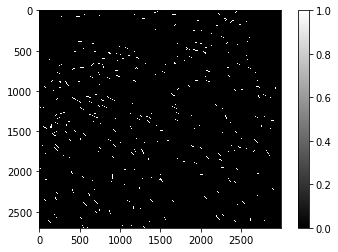

In [153]:
plt.imshow(smallBiamge['rod'],cmap='gray')
plt.colorbar()

In [124]:
print (bimage['rod'].shape)

(5730, 10980)


In [112]:
pcc = {}
for i in combo:
     pcc[str(i[0])+"_"+str(i[1])] = 2.0

In [113]:
print (pcc.keys())

dict_keys(['ram_rod', 'ram_hyp', 'ram_amoe', 'ram_dys', 'rod_hyp', 'rod_amoe', 'rod_dys', 'hyp_amoe', 'hyp_dys', 'amoe_dys'])


In [86]:
>>> for combo in itertools.combinations([(1,1), (2,2), (3,3), (4,4)], 2):
...     print(combo)
...
((1, 1), (2, 2))
((1, 1), (3, 3))
((1, 1), (4, 4))
((2, 2), (3, 3))
((2, 2), (4, 4))
((3, 3), (4, 4))

(5730, 10980)


In [31]:
sqY = np.sort(squareform(Y),axis=1)

In [34]:
print (squareform(Y))

[[0.         2.23606798 2.23606798 2.23606798 3.16227766]
 [2.23606798 0.         2.         3.16227766 2.23606798]
 [2.23606798 2.         0.         1.41421356 1.        ]
 [2.23606798 3.16227766 1.41421356 0.         2.23606798]
 [3.16227766 2.23606798 1.         2.23606798 0.        ]]


In [37]:
print (np.mean(sqY[:,1]))

1.530056307974577


<Figure size 1800x1200 with 0 Axes>

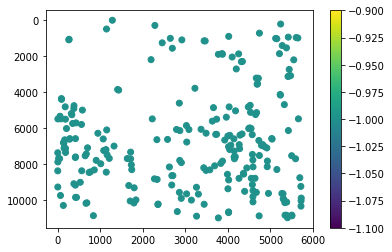

In [50]:
db.fit(locations['ram'])

plt.figure(figsize=(6,4),dpi=300)
fig, ax = plt.subplots()
im = ax.scatter(locations['ram'][:,0], locations['ram'][:,1], c=db.labels_)
plt.gca().invert_yaxis()
cbar = fig.colorbar(im, ax=ax)
#cbar.ax.set_xticklabels(['None', 'Noise', 'None'])  # horizontal colorbar

In [51]:
print (db.labels_)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
